In [1]:
import numpy as n
from matplotlib import pyplot as plt
import os
import numpy.lib.recfunctions as rfn

In [2]:
from scipy.signal import spectrogram, find_peaks

In [3]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / n.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (n.arccos(n.clip(n.dot(v1_u, v2_u), -1.0, 1.0)))

In [4]:
def load_data(data_root, dlc_dir, ann_dir, verbose=False):
    
    dlc_path = os.path.join(data_root, dlc_dir)
    ann_path = os.path.join(data_root, ann_dir)
    all_data = {}
    if verbose: print("Loading files: ")
    for f_name in os.listdir(dlc_path):
        if f_name[-3:] != 'npy':
            continue

        dlc_file=os.path.join(dlc_path, f_name)
        ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
        if verbose: print("\t" + f_name + "\n\tAnnotated_" + f_name)
        data_dlc = n.load(dlc_file)
        data_ann = n.load(ann_file)
        labels = data_dlc[0]
        dtype = [('t', n.int), ('ann', 'U30')]
        i = 0
        for label in data_dlc[0]:
            i += 1
            coord = 'x' if i % 2 == 0 else 'y'
            dtype += [(label + '_' + coord , n.float32 )]

        data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
        data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
        for i in range(data_concat.shape[1]):
            data[dtype[i][0]] = data_concat[:, i]
        all_data[f_name[:-4]] = data
    return all_data

In [5]:
def calculate_velocity(trial):
    names = []; dtypes = []; datas = []
    velocities_calculated = []
    for label in trial.dtype.names:
        if label[-2:] in ['_x', '_y']:
            names.append(label+'_vel') 
            dtypes += [n.float]
            datas += [n.zeros(trial.shape[0])]
#             if calculate_f:
                
            velocities_calculated.append(label)
    trial = rfn.append_fields(trial, names, datas, dtypes)
    trial = n.array(trial, trial.dtype)
    for label in velocities_calculated:
        vel = n.gradient(trial[label])
        trial[label + '_vel'] = vel
    return trial

In [6]:
def extract_data(trial):
    num_markers = int((len(trial.dtype.names)-2)/2)

    all_labels = trial.dtype.names[2:]

    markers_1 = []
    markers_2 = []
    positions_1 = n.zeros((trial.shape[0], int(num_markers/2), 2))
    positions_2 = n.zeros((trial.shape[0], int(num_markers/2), 2))

    for i in range(num_markers):
        label = all_labels[i*2][:-2]
        label_x = label+'_x'
        label_y = label+'_y'
        if label[-1] == '1':
            markers_1.append(label)
            idx = len(markers_1)-1
            positions_1[:,idx, 0] = trial[label_x]
            positions_1[:,idx, 1] = trial[label_y]
        else:
            markers_2.append(label)
            idx = len(markers_2)-1
            positions_2[:,idx,0] = trial[label_x]
            positions_2[:,idx,1] = trial[label_y]
    return n.array(markers_1), n.array(markers_2), positions_1, positions_2

In [7]:
def convert_to_ego(mark_1, mark_2, pos_1, pos_2, anchor_label='GreenTape_1', anchor_2_label='RedTape_1'):
    anchor_idx = n.where(mark_1==anchor_label)[0][0]
    anchor_2_idx =  n.where(mark_1==anchor_2_label)[0][0]
    pos_1_ego = pos_1.copy()
    pos_2_ego = pos_2.copy()

    pos_1_ego = pos_1_ego - n.stack([[pos_1[:,anchor_idx]]]*pos_1.shape[1], axis=2)[0]
    pos_2_ego = pos_2_ego - n.stack([[pos_1[:,anchor_idx]]]*pos_1.shape[1], axis=2)[0]

    for t in range(pos_1_ego.shape[0]):
        anchor_vector = pos_1_ego[t,anchor_2_idx].copy()
        angle = -angle_between(anchor_vector, n.array((1,0)))
        if n.all(anchor_vector[1] < 0): angle *= -1
        for i in range(pos_1_ego.shape[1]):
            vector_1 = pos_1_ego[t,i]
            x_1 = n.cos(angle) * vector_1[0] - n.sin(angle) * vector_1[1]
            y_1 = n.sin(angle) * vector_1[0] + n.cos(angle) * vector_1[1]
            pos_1_ego[t,i] = [x_1, y_1]

            vector_2 = pos_2_ego[t,i]
            x_2 = n.cos(angle) * vector_2[0] - n.sin(angle) * vector_2[1]
            y_2 = n.sin(angle) * vector_2[0] + n.cos(angle) * vector_2[1]
            pos_2_ego[t,i] = [x_2, y_2]
    return pos_1_ego, pos_2_ego

In [35]:
def calc_spec(pos, mark, label, nperseg=64, nfft=512, noverlap=None, mag=True,plot=True, vmin=0, vmax=300, ylim=(0,5)):
    idx = n.where(mark==label)[0][0]
    if mag:
        to_spec_data = n.sqrt(pos[:,idx,0]**2 + pos[:,idx,1]**2)
        f,t,Sxx = spectrogram(to_spec_data, fs=fps, nperseg=nperseg, nfft=nfft)
    else:
        x_data = pos[:,idx,0]
        y_data = pos[:,idx,1]
        
        f,t, Sxx_x = spectrogram(x_data, fs=fps, nperseg=nperseg, nfft=nfft)
        __, __, Sxx_y = spectrogram(y_data, fs=fps, nperseg=nperseg, nfft=nfft,noverlap=noverlap)
        
        Sxx = Sxx_x + Sxx_y
    if not plot:
        return f,t,Sxx
    
    fig,ax = plt.subplots(figsize=(12,6))
    plt.pcolormesh(t, f, Sxx, shading='nearest', vmin=vmin, vmax= vmax)
    plt.colorbar()
    plt.ylim(ylim)
    
    return f,t,Sxx, fig,ax

In [21]:
def get_heatmap(Sxx, ts, pos, xs, ys,  poi_idx, freq_range=(17,20)):
    xx, yy = n.meshgrid(xs,ys)
    powers = n.zeros(xx.shape)
    counts = n.zeros(xx.shape)
    freq_min = freq_range[0]
    freq_max = freq_range[1]
    for t_idx, t in enumerate(ts):
        x,y = pos[int(t*fps), poi_idx]
        if n.any(n.isnan(n.array([x,y]))): 
            continue

        x_where = n.where(x > xs)[0]
        y_where = n.where(y > ys)[0]
        if x_where.shape[0] == 0: x_idx = 0
        else: x_idx = x_where[-1]

        if y_where.shape[0] == 0: y_idx = 0
        else: y_idx = y_where[-1]

        counts[x_idx, y_idx] += 1
        powers[x_idx, y_idx] += n.mean(Sxx[freq_min:freq_max, t_idx])
    powers /= counts 
    
    return xx, yy, powers, counts

### Load data files
`data_root` should contain the root directory of the folder downloaded from Dropbox.

In [10]:
fps = 40

In [76]:
data_root = '/mnt/d/Ali/Google Drive/SWC/Experimental Neuroscience/social and affective systems/rat_social_beh'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'

dlc_path = os.path.join(data_root, dlc_dir)
ann_path = os.path.join(data_root, ann_dir)

all_data = load_data(data_root, dlc_dir, ann_dir)
trial = all_data['Female1']
trial = [all_data[key] for key in all_data]

In [77]:
trial = n.concatenate(trial)

In [79]:
mark_1, mark_2, pos_1, pos_2 = extract_data(trial)

In [80]:
pos_1_ego, pos_2_ego = convert_to_ego(mark_1, mark_2, pos_1, pos_2)

In [14]:
# vel_1_ego = n.gradient(pos_1_ego, axis=0)
# vel_2_ego = n.gradient(pos_2_ego, axis=0)

In [81]:
spec_label = 'NapeCenter_1'
poi_label = 'InteracteeTailBase_2'
poi_idx = n.where(mark_2==poi_label)[0][0]
extent = 100
n_grid = 10
x_offset = 20
y_offset = 50
nperseg = 64
nfft = 512

/home/ali/anaconda3/envs/gp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


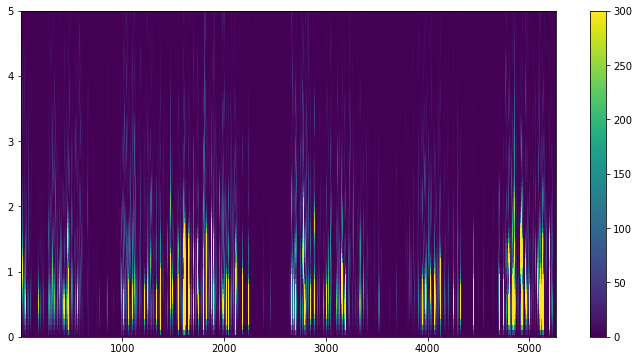

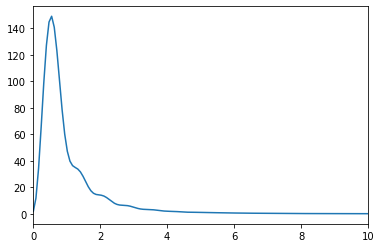

In [82]:
f,ts,Sxx,fig,ax = calc_spec(pos_1_ego, mark_1, spec_label, nperseg=nperseg, nfft=nfft, plot=True)
plt.figure()
plt.plot(f,Sxx.mean(axis=1))
plt.xlim(0,10)
xs = n.linspace(-extent+x_offset, extent+x_offset, n_grid)
ys = n.linspace(-extent+y_offset,extent+y_offset,n_grid)

xx, yy, powers, counts = get_heatmap(Sxx, ts, pos_2_ego, xs, ys, poi_idx)

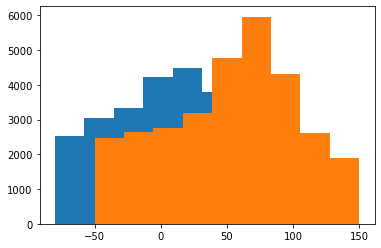

In [84]:
plt.hist(pos_2_ego[:,poi_idx,0], bins=xx[0]);
plt.hist(pos_2_ego[:,poi_idx,1], bins=yy[:,0]);
# plt.xlim(-200, 200)
# plt.xlim(-extent, extent)

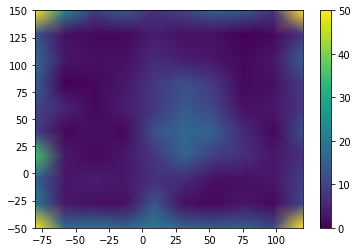

In [88]:
plt.pcolormesh(xx, yy, counts, shading='gouraud', vmin=0, vmax=50)
plt.colorbar()

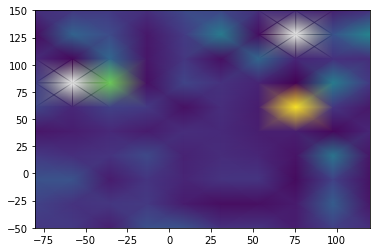

In [89]:
plt.pcolormesh(xx, yy, powers, shading='gouraud')